In [17]:
import pandas as pd
import numpy as np
import operator
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from random import shuffle

In [2]:
data = pd.read_csv('pima-indians-diabetes.data.csv')
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
data.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

# Data Analysis

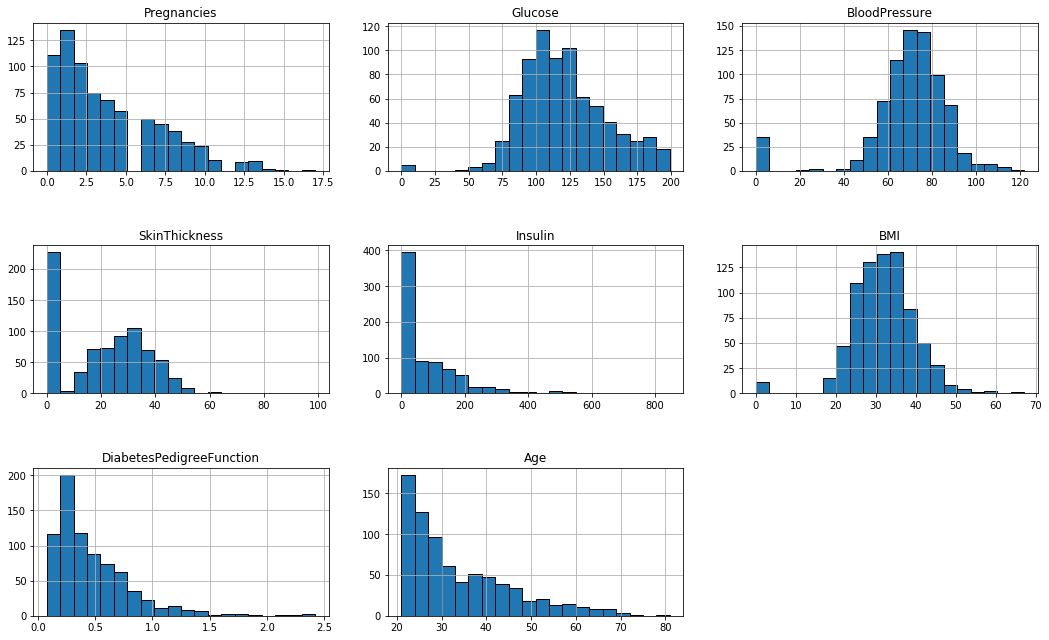

In [3]:
columns=data.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    data[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

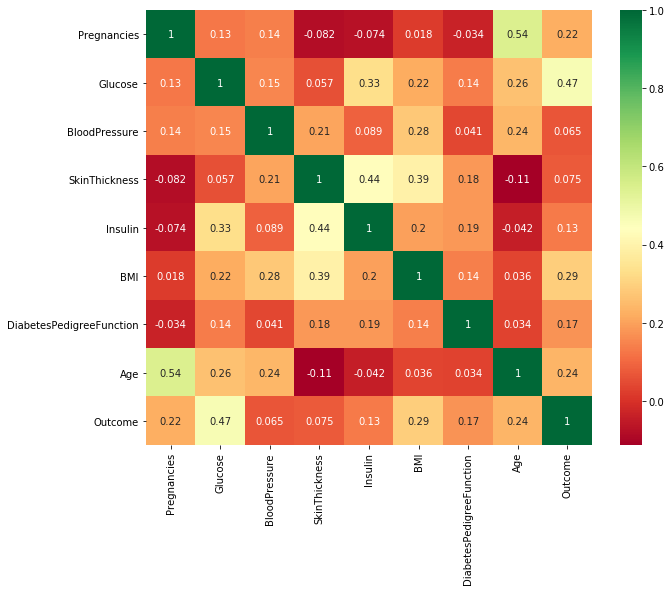

In [4]:
sns.heatmap(data[data.columns[:9]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

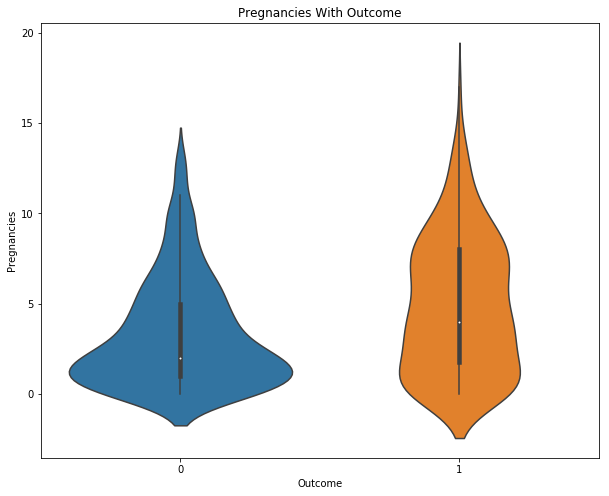

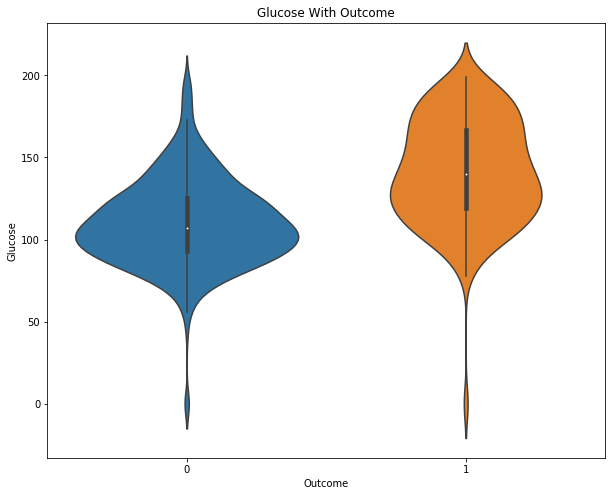

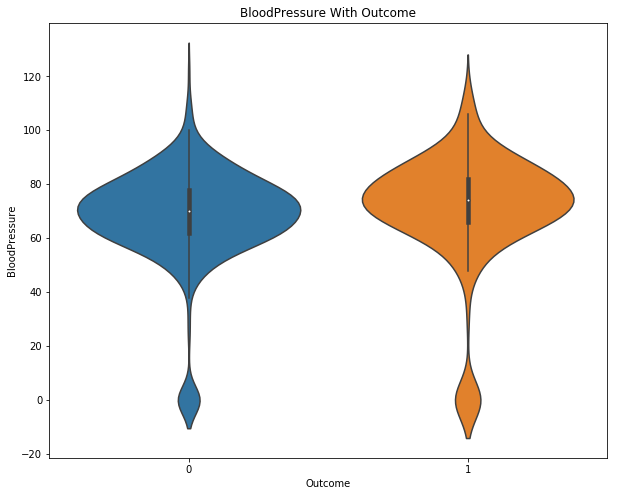

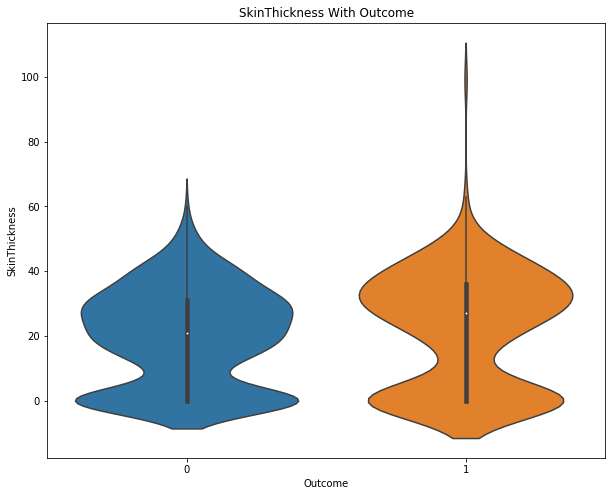

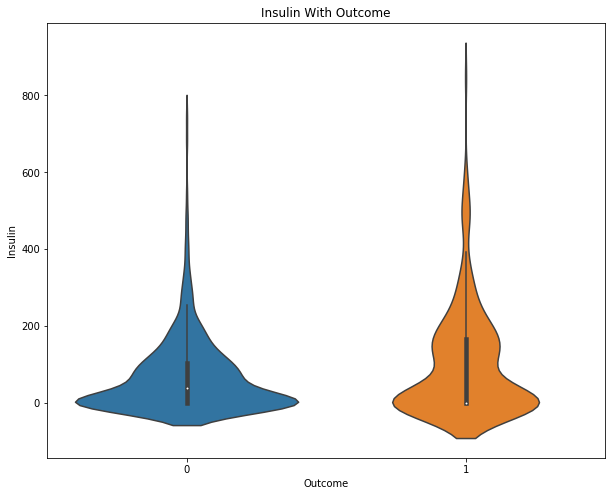

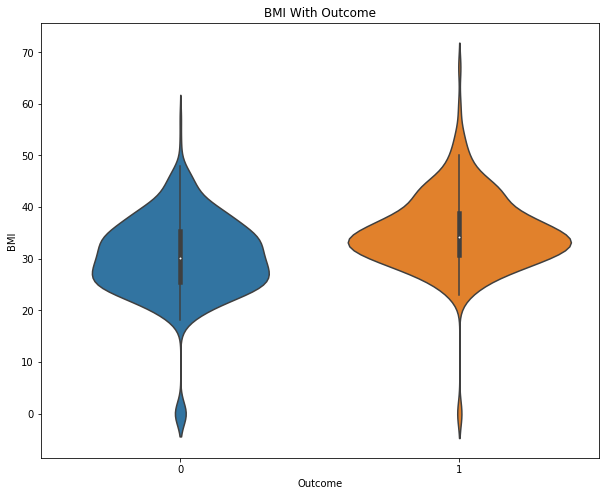

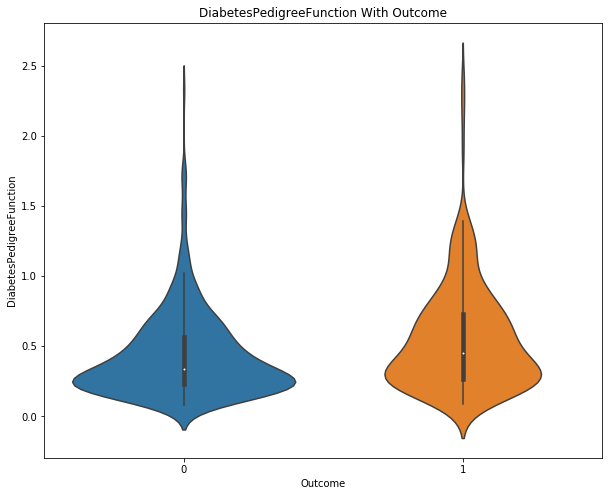

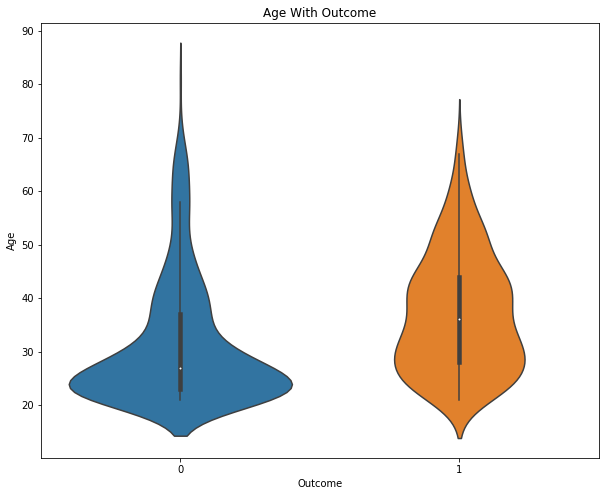

In [5]:
cols = data.columns[:8]
for item in cols:
    plt.figure(figsize=(10, 8))
    plt.title(str(item) + ' With' + ' Outcome')
    sns.violinplot(x=data.Outcome, y=data[item], data=data)
    plt.show()

/Users/bogdanivanyuk/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/bogdanivanyuk/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/bogdanivanyuk/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/bogdanivanyuk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


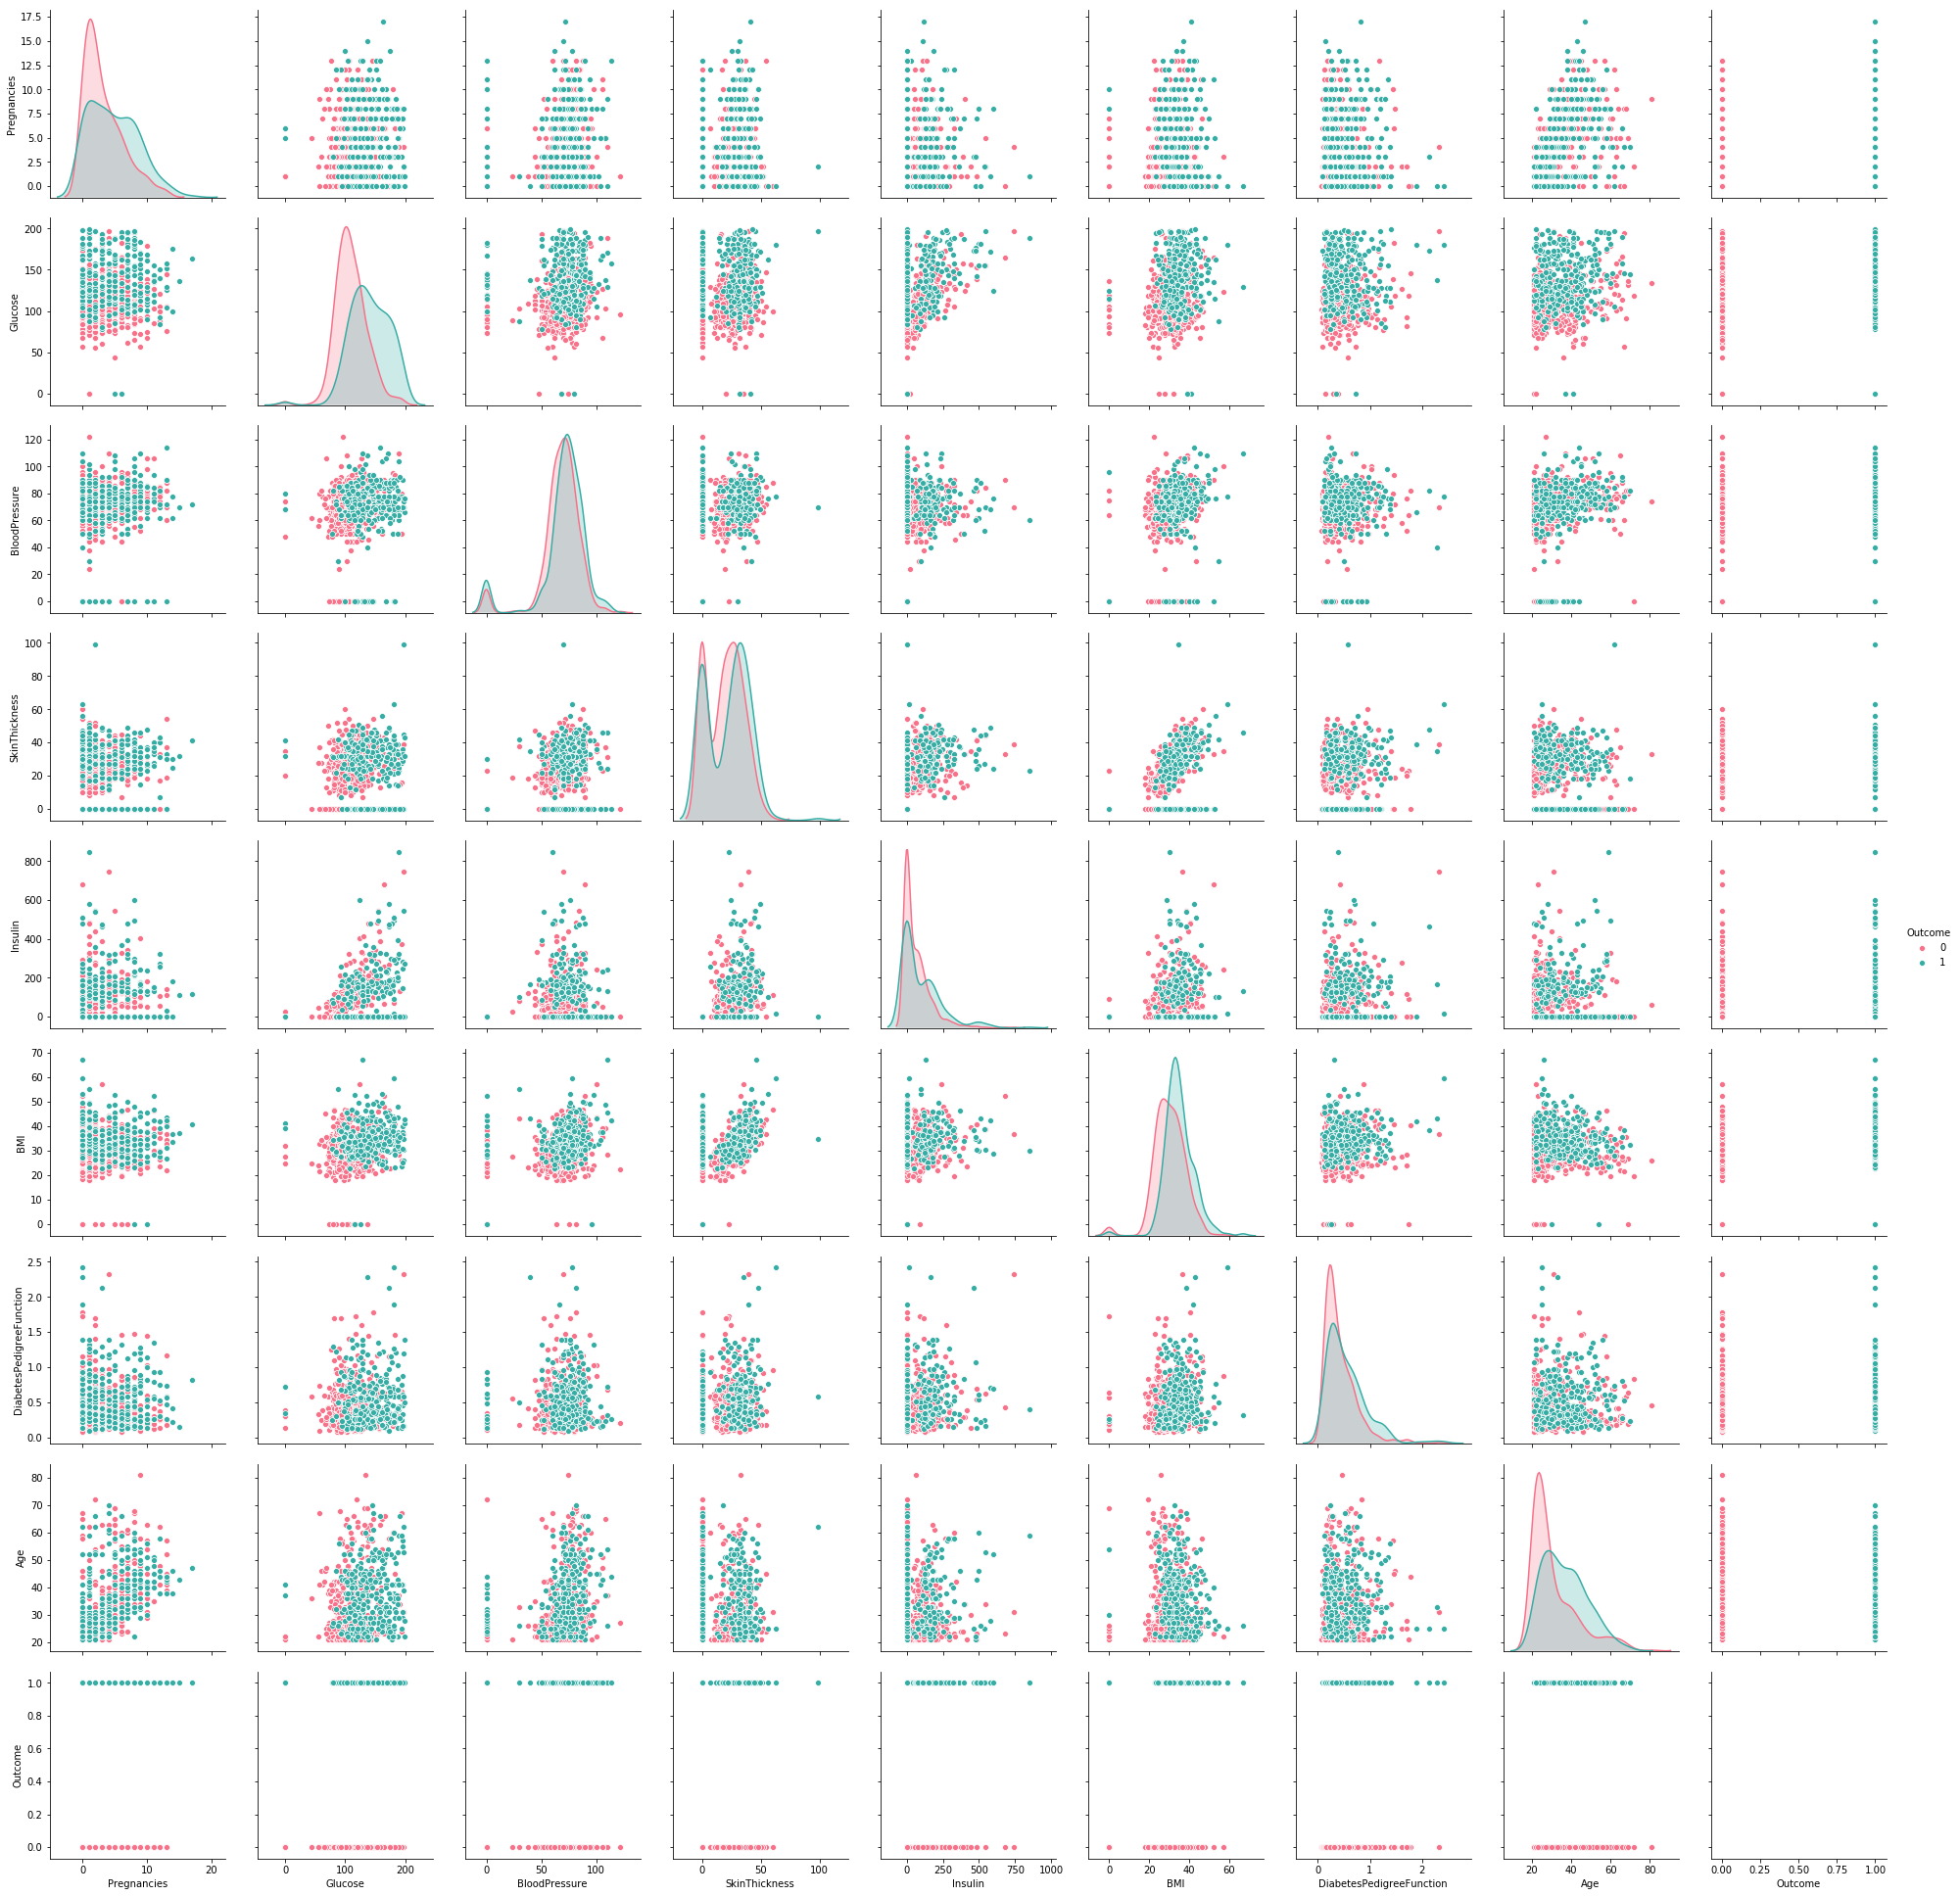

In [6]:
sns.pairplot(data, size=3, hue='Outcome', palette='husl',)
plt.show()

In [7]:
#Breaking the data into training and test set
import random
def train_test_split(data, split, trainingSet = [], testSet = []):
    for x in range(len(data)):
        if random.random() < split:
            trainingSet.append(data[x])
        else:
            testSet.append(data[x])
trainingSet = []
testSet = []
split = 0.95
train_test_split(data.values.tolist(), split, trainingSet, testSet)

In [13]:
#Define Euclidean distances
import math
def Euclideandist(x,xi, length):
    d = 0.0
    for i in range(length):
        d += pow(float(x[i])- float(xi[i]),2)
    return math.sqrt(d)

In [26]:
def reduction(data, class_number, n_observations):
    centroids = []
    data_points = []
    for i in range(class_number): # creating centroids for each class
        data_class = [t[:] for t in data if t[-1]==i]
        centroids.append(np.array(data_class).mean(axis=0))
        distances = []
        length = len(centroids[i])-1
        for x in range(len(data)):
            dist = Euclideandist(centroids[i], trainingSet[x], length)
            distances.append((trainingSet[x], dist))
        distances.sort(key=operator.itemgetter(1))
        for x in range(n_observations):
            data_points.append(distances[x][0])
    return data_points
trainingSet = reduction(trainingSet, 2, 200)
print(len(trainingSet))

400


In [27]:
#Getting the K neighbours having the closest Euclidean distance to the test instance
import operator
def getNeighbors_knn(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = Euclideandist(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [28]:
#Getting neighbours in the range of a window
import operator
def getNeighbors_parzen(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = Euclideandist(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    dist_index = [x[1] for x in distances]
    neighbors = []
    i = 0
    while dist_index[i] < k: 
        neighbors.append(distances[i][0])
        i+=1
    return neighbors

In [29]:
#After sorting the neighbours based on their respective classes, max voting to give the final class of the test instance
import operator
def getResponse(neighbors, x):
    classVotes = {}
    if len(neighbors) == 0:
        print('Increase size of a window, because observation'+str(x)+' can not be classified')
        return
    else:
        for x in range(len(neighbors)):
            response = neighbors[x][-1]
            if response in classVotes:
                classVotes[response] += 1
            else:
                classVotes[response] = 1
        sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)#Sorting it based on votes
        return sortedVotes[0][0] #Please note we need the class for the top voted class, hence [0][0]#

In [30]:
#Accuracy function
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

In [31]:
# generate predictions
predictions=[]
k = 15
for x in range(len(testSet)):
    neighbors = getNeighbors_knn(trainingSet, testSet[x], k)
    result = getResponse(neighbors, 1)
    predictions.append(result)
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: ' + repr(accuracy) + '%')
print(predictions)

Accuracy: 72.22222222222221%
[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]


In [32]:
# generate predictions
predictions=[]
k = 35
for x in range(len(testSet)):
    neighbors = getNeighbors_parzen(trainingSet, testSet[x], k)
    result = getResponse(neighbors, x)
    predictions.append(result)
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: ' + repr(accuracy) + '%')
print(predictions)

Increase size of a window, because observation0 can not be classified
Increase size of a window, because observation5 can not be classified
Increase size of a window, because observation6 can not be classified
Increase size of a window, because observation11 can not be classified
Increase size of a window, because observation20 can not be classified
Increase size of a window, because observation23 can not be classified
Increase size of a window, because observation28 can not be classified
Increase size of a window, because observation31 can not be classified
Increase size of a window, because observation32 can not be classified
Increase size of a window, because observation33 can not be classified
Accuracy: 50.0%
[None, 1.0, 0.0, 0.0, 1.0, None, None, 0.0, 0.0, 0.0, 0.0, None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 0.0, None, 0.0, 0.0, 1.0, 0.0, None, 0.0, 0.0, None, None, None, 1.0, 0.0]
